# Load libraries

In [56]:
import pandas as pd
import re

# Scrap de datos

# Lectura del archivo

In [55]:
# Load the data from the provided text file previously scrapped from Reddit subreddit /teenagers
data = pd.read_csv('teenagers_posts_2024-07-12_15-02-29.txt', delimiter='\t', header=None, names=['post', 'label'])

# Txt to csv file

In [57]:
data.to_csv('teenagers_posts.csv', index=False)

# Data rows to columns

In [58]:
file_path = 'teenagers_posts.csv'
data = pd.read_csv(file_path)
data = data.rename(columns={'post':'entrada','label':'label'})

# Create 'title' and 'selftext' columns
data['title'] = ''
data['selftext'] = ''

# Separate 'post' into 'title' and'selftext'
for i in range(len(data['entrada'])):
    if re.match(r'^Title:', data['entrada'][i]):
        data['title'][i] = data['entrada'][i]
    elif re.match(r'^Selftext:', data['entrada'][i]):
        data['selftext'][i-1] = data['entrada'][i]

# Remove 'entrada' column and rows with empty 'title' and 'selftext' columns
data = data.drop(columns=['entrada'])
data = data[data["title"] != '']

C:\Users\Jordi\AppData\Local\Temp\ipykernel_14392\1878940974.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['title'][i] = data['entrada'][i]
C:\Users\Jordi\AppData\Local\Temp\ipykernel_14392\1878940974.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['selftext'][i-1] = data['entrada'][i]
C:\Users\Jordi\AppData\Local\Temp\ipykernel_14392\1878940974.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['title'][i]

In [59]:
# Result
print(data.head(10))
data.to_csv('teenagers_posts.csv', index=False)

    label                                              title  \
0     NaN  Title: Is it gayer to have a relationship with...   
2     NaN                         Title: Quitting porn day 1   
4     NaN                 Title: nah yeah mudcrabs are GIANT   
6     NaN  Title: I feel like I'm gonna tranced to a diff...   
8     NaN  Title: does anyone else get horrifically down ...   
12    NaN  Title: Gonna buy some condoms a ski mask and a...   
14    NaN                           Title: how should i feel   
16    NaN  Title: Im from phillipines and most people whe...   
18    NaN                        Title: Best midnight snack?   
20    NaN  Title: Holy shit I looked in the mirror and my...   

                                             selftext  
0   Selftext: So I have a friend who got touched b...  
2   Selftext: I don’t even watch porn but everyone...  
4          Selftext: like genuinely they look giant 😭  
6              Selftext: No I'm not high on anything🙏  
8   Selftext: o

# Creación del DataFrame

In [60]:
# Load CSV into DataFrame
file_path = 'teenagers_posts.csv'
data = pd.read_csv(file_path)

# Merge 'title' and 'selftext' into a new column 'merged_text'
data['merged_text'] = data['title'] + ' ' + data['selftext']

# Drop 'title' and 'selftext' columns
data.drop(columns=['title', 'selftext'], inplace=True)

# Rearrange columns
cols = data.columns.tolist()
cols = ['merged_text'] + [col for col in cols if col != 'merged_text']
data = data[cols]

# Rename 'merged_text' column to 'posts'
data.rename(columns={'merged_text': 'posts'}, inplace=True)
data.head()

,posts,label
0,Title: Is it gayer to have a relationship with...,NaN
1,Title: Quitting porn day 1 Selftext: I don’t e...,NaN
2,Title: nah yeah mudcrabs are GIANT Selftext: l...,NaN
3,Title: I feel like I'm gonna tranced to a diff...,NaN
4,Title: does anyone else get horrifically down ...,NaN


In [61]:
# Remove Title and Selftext words
for i in range(len(data['posts'])):
    data['posts'][i] = re.sub(r'Title: ', '' , data['posts'][i]) #UwU
    data['posts'][i] = re.sub(r'Selftext: ', '' , data['posts'][i])

C:\Users\Jordi\AppData\Local\Temp\ipykernel_14392\2238465400.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['posts'][i] = re.sub(r'Title: ', '' , data['posts'][i]) #UwU
C:\Users\Jordi\AppData\Local\Temp\ipykernel_14392\2238465400.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['posts'][i] = re.sub(r'Selftext: ', '' , data['posts'][i])
C:\Users\Jordi\AppData\Local\Temp\ipykernel_14392\2238465400.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [62]:
print(data['posts'][0])
print(data['posts'][1])
print(data['posts'][2])

Is it gayer to have a relationship with a man or to fuck a man once  So I have a friend who got touched by his uncle.
Quitting porn day 1 I don’t even watch porn but everyone’s doing it so why not
nah yeah mudcrabs are GIANT like genuinely they look giant 😭


In [63]:
# Save modified DataFrame back to CSV file
modified_file_path = 'teenagers_posts_modified.csv'
data.to_csv(modified_file_path, index=False)

# Data Cleansing

In [64]:
# Load CSV into DataFrame
file_path = 'teenagers_posts_modified.csv'
data = pd.read_csv(file_path)


# Function to remove special characters, URLs, and unnecessary whitespace
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove special characters and numbers (retain only letters)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Normalize spaces to single space and convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip().lower()
    
    return text


# Apply clean_text function to 'posts' column
data['posts'] = data['posts'].apply(clean_text)


# Print first few rows to verify
data.info()
print('\n\n', data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   posts   997 non-null    object 
 1   label   0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 15.7+ KB


                                                posts  label
0  is it gayer to have a relationship with a man ...    NaN
1  quitting porn day i dont even watch porn but e...    NaN
2  nah yeah mudcrabs are giant like genuinely the...    NaN
3  i feel like im gonna tranced to a different re...    NaN
4  does anyone else get horrifically down atrocio...    NaN


In [65]:
# Save cleaned DataFrame back to CSV file
cleaned_file_path = 'teenagers_cleaned.csv'
data.to_csv(cleaned_file_path, index=False)

# Dataset labeling

Criteria for depression labeling:
+ Expressions of persistent sadness, hopelessness, or emptiness.
+ Mentions of losing interest in activities once enjoyed.
+ Statements indicating feelings of worthlessness or excessive guilt.
+ Posts discussing fatigue, low energy, or sleep disturbances related to mood.
+ Descriptions of difficulty concentrating or making decisions.
+ Mentions of significant weight changes or appetite changes due to mood.

Criteria for suicidal tendencies labeling:
+ Explicit mentions of wanting to die or commit suicide.
+ Statements indicating plans or methods for committing suicide.
+ Posts expressing a desire to escape life or end one's suffering.
+ References to self-harm with suicidal intent.
+ Expressions of severe despair with no perceived way out.

Critera for neutral/other posts
+ Posts that do not express any symptoms or indicators of depression or suicidal tendencies.
+ General discussions, questions, or statements about daily life, interests, or activities.
+ Positive or neutral expressions, including casual conversations, jokes, or light-hearted content.

Labeling:
+ No Depression / No Suicidal Thoughts:
Text does not indicate any signs of depression or suicidal thoughts.

+ Mild Depression:
Text shows subtle signs or mild expressions of sadness, hopelessness, or lack of interest.

+ Moderate Depression:
Text indicates moderate levels of depressive symptoms, such as persistent sadness, decreased energy, or changes in sleep or appetite.

+ Severe Depression:
Text reflects severe depressive symptoms, including intense feelings of despair, significant loss of interest in activities, or thoughts of worthlessness.

+ Mild Suicidal Thoughts:
Text contains passive or fleeting thoughts about death or suicide without specific plans or intent.

+ Moderate Suicidal Thoughts:
Text includes more persistent or frequent thoughts about death or suicide, sometimes with vague plans or ideation.

+ Severe Suicidal Thoughts:
Text indicates intense and persistent thoughts of suicide, often with specific plans, intent, or preparatory behaviors.

+ Positive / Coping:
Text shows positive coping mechanisms, resilience, or strategies for managing stress or difficult emotions.

+ Mixed Features:
Text contains elements of both depressive symptoms and suicidal thoughts, which may vary in intensity or co-occurrence.

+ Uncertain / Ambiguous: Text is unclear or ambiguous in terms of emotional state or symptoms related to depression or suicidal thoughts.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [67]:
import pandas as pd

data = pd.read_csv('teenagers_cleaned.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   posts   997 non-null    object 
 1   label   0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 15.7+ KB


In [68]:
# Define labels 
labels = {
    'Positive': ['happy', 'content', 'normal', 'satisfied', 'positive', 'joyful', 'cheerful', 'carefree', 'peaceful', 'calm', 'stable', 'balanced', 'serene', 'hopeful', 'fulfilled', 'optimistic', 'lively', 'energetic', 'vibrant', 'thriving', 'well-adjusted', 'resilient', 'upbeat', 'buoyant', 'enthusiastic', 'lively', 'elated','resilient', 'coping', 'managing stress', 'problem-solving', 'optimistic', 'hopeful', 'supportive relationships', 'exercise', 'hobbies', 'blessed', 'life is good', 'life is beautiful', "i feel great today", "i'm so happy right now", "i feel so content", "i can't stop smiling", "i'm in such a good mood", "i feel so joyful", "everything is going well", "i love my life", "i'm so grateful for everything", "today is a wonderful day", "i feel on top of the world", "i'm really enjoying myself", "i'm so excited about the future", "i feel so lucky", "i'm surrounded by love", "i feel so alive", "i'm so happy with my progress", "i can't wait to see what happens next", "i feel so at peace", "everything feels right", "i feel so balanced", "i feel so calm and relaxed", "i'm so at ease", "i feel so grounded", "i feel so connected", "i feel so stable", "i feel so secure", "i feel so comfortable", "i feel so optimistic", "i see the good in everything", "i believe in myself", "i feel so empowered", "i'm looking forward to the future", "i feel so motivated", "i have a positive outlook", "i'm confident in my abilities", "i feel so inspired", "i feel so hopeful", "i feel so healthy", "i'm taking good care of myself", "i feel so energetic", "i'm in great shape", "i feel so vibrant", "i feel so refreshed", "i feel so strong", "i feel so revitalized", "i feel so rejuvenated", "i feel so fit", "i'm really satisfied with my life", "i feel so fulfilled", "i'm happy with how things are going", "i feel so accomplished", "i'm proud of myself", "i feel so successful", "i'm pleased with my progress", "i feel so rewarded", "i feel so appreciated", "i feel so valued", "i'm so thankful for everything i have", "i appreciate all the good in my life", "i'm grateful for my family and friends", "i'm thankful for the little things", "i appreciate the beauty around me", "i'm grateful for my health", "i feel so lucky to be alive", "i'm thankful for my experiences", "i appreciate every moment"],
    'Mixed Features': ['conflicted', 'ambivalent', 'up and down', 'uncertain', 'mood swings', 'coping and struggling', 'swinging emotions','unsure', 'confused', 'unclear', 'mixed feelings', 'uncertain emotions', 'difficult to understand', 'unclear thoughts', "i'm not sure how I feel about this", "i have mixed emotions", "it's a bit of both, good and bad", "i feel conflicted", "i don't know what to think", "i'm happy, but also a little sad", "i'm excited, but also nervous", "i feel a sense of relief, but also worry", "i'm grateful, but it's bittersweet", "i'm feeling both hope and fear", "i'm torn between two feelings", "i can't decide if this is good or bad", "i feel both joy and sorrow", "i'm both satisfied and dissatisfied", "i have a sense of achievement, but also regret", "i'm happy with the outcome, but the process was tough", "i'm relieved, but still uncertain", "i feel proud, but there's a tinge of sadness", "i'm both anxious and excited", "i feel fulfilled, but also exhausted", "i'm not sure if this is right", "i can't tell if I'm making the right choice", "i feel unsure about my feelings", "i'm uncertain about the future", "i don't know if i should be happy or sad", "i feel confused about my emotions", "i'm questioning how i feel", "i have doubts about this", "i'm unsure if this is a good thing", "i don't know what to feel", "it's complicated", "there are so many layers to this", "it's not black and white", "i have a lot of thoughts about this", "it's a mix of emotions", "it's a tough situation", "i'm feeling a lot of different things", "it's hard to put into words", "i'm experiencing conflicting emotions", "it's both good and bad", "i'm not sure what to expect", "it could go either way", "the outcome is uncertain", "i'm not sure how things will turn out", "it's unpredictable", "i don't know what's going to happen", "it could be a blessing or a curse", "i'm waiting to see how it unfolds", "it's still up in the air", "the results are unclear", "i'm happy if it works out", "i'll be okay depending on the outcome", "it all depends on what happens next", "i'll feel better if things go as planned", "my feelings are conditional on the situation", "i'm optimistic if things go right", "i'll be content if it resolves well", "i'm hopeful if there's a positive turn", "it will be great if it succeeds", "i'm anxious unless i see progress", "i'm starting to feel better", "it's getting easier over time", "i'm slowly coming to terms with it", "it's a gradual improvement", "i'm beginning to understand", "it's getting clearer with time", "i'm warming up to the idea", "it's taking time, but i'm getting there", "i'm adjusting little by little", "it's a slow but steady process"],
    'Depression/Suicidal Thoughts': ['sad', 'blue', 'down', 'low', 'unhappy', 'gloomy', 'discouraged', 'disinterested', 'unmotivated', 'indifferent', 'apathetic', 'listless', 'melancholic', 'withdrawn', 'quiet', 'mellow', 'subdued', 'contemplative', 'introspective', 'reflective', 'somber', 'despondent', 'forlorn', 'morose', 'melancholy','depressed', 'hopeless', 'helpless', 'tired', 'fatigued', 'irritable', 'restless', 'agitated', 'anxious', 'stressed', 'overwhelmed', 'burdened', 'somber', 'pensive', 'brooding', 'introspective', 'moody', 'despondent', 'troubled', 'disheartened','moody', 'despondent', 'troubled', 'disheartened', 'dejected', 'discouraged', 'bleak', 'dismal', 'wretched', 'distressed', 'haunted', 'despair', 'worthlessness', 'guilt', 'emptiness', 'numbness', 'isolation', 'loneliness', 'misery', 'anguish', 'sorrow', 'grief', 'devastated', 'devastated', 'anguish', 'agony', 'hopeless', 'suicidal', 'inconsolable', 'apathetic', 'thoughts','death', 'die', 'end it', 'disappear', 'escape', 'peaceful', 'painless', 'no reason to live','suicidal', 'planning', 'thinking about death', 'ways to die', 'unbearable pain', 'ending life', 'giving up','suicide', 'intent', 'method', 'preparation', 'goodbye letters', 'final arrangements', 'goodbye messages', 'suicide note', "what's the point of life", "I can't keep up anymore", "I feel worthless", "I can't keep up anymore", "I feel empty inside", "nothing makes me happy anymore", "i feel hopeless", "i can't see a way out", "i don't care about anything", "i feel like a burden", "everything feels pointless", "i have no motivation to do anything", "i can't stop crying", "i feel numb", "i can't concentrate on anything", "i feel so alone", "i'm exhausted all the time", "i can't find joy in things i used to love", "i feel like i'm drowning", "i'm just so tired", "i can't see a future for myself", "i feel like i'm falling apart", "i don't have the energy to get out of bed", "i wish i could just disappear", "i can't go on like this", "everyone would be better off without me", "i can't handle this pain anymore", "i don't want to be here anymore", "i can't take this anymore", "i feel like giving up", "i just want everything to stop", "i don't want to wake up", "i feel like there's no escape", "i've been thinking about ending it all", "i can't live with this pain", "i feel like my life is over", "i just want the pain to end", "i don't think i can keep going", "life feels unbearable", "i'm overwhelmed by my emotions", "i feel like i'm in a dark hole", "i can't escape these thoughts", "everything feels heavy", "i can't stop these dark thoughts", "i feel completely worthless", "i can't handle the pressure anymore", "i'm drowning in my own mind", "i'm losing control", "i'm at the end of my rope", "i don't see any point in living", "i can't keep fighting", "i'm suffocating", "i've lost the will to live"],
}

In [ ]:
# Flatten the labels dictionary
flattened_labels = {word: category for category, words in labels.items() for word in words}

# Function to categorize labels based on presence in text
def categorize_label(text):
    text = text.lower()  # Ensure the text is in lowercase for matching
    words = text.split()
    
    for category, keywords in labels.items():
        if any(word in words for word in keywords):
            return category
    return 'Neutral'  # Return 'Neutral' if no match found

# Read the CSV file into a DataFrame
file_path = 'teenagers_cleaned.csv'
data = pd.read_csv(file_path)

# Apply label categorization function
data['label'] = data['posts'].astype(str).apply(lambda x: categorize_label(x))

# Print the first few rows of the DataFrame to check the result
print(data.head())
print('\n')
data.info()
print('\n\n', data['label'].value_counts())

                                               posts  \
0  is it gayer to have a relationship with a man ...   
1  quitting porn day i dont even watch porn but e...   
2  nah yeah mudcrabs are giant like genuinely the...   
3  i feel like im gonna tranced to a different re...   
4  does anyone else get horrifically down atrocio...   

                          label  
0                       Neutral  
1                       Neutral  
2                       Neutral  
3                       Neutral  
4  Depression/Suicidal Thoughts  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   posts   997 non-null    object
 1   label   997 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB


 label
Neutral                         910
Depression/Suicidal Thoughts     58
Positive                         22
Mixed Features                    7
Name: count, dt

In [70]:
# Save the DataFrame with the new labels back to a CSV file (optional)
output_file_path = 'teenagers_labeled.csv'
data.to_csv(output_file_path, index=False)

# Tokenización

In [80]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

ModuleNotFoundError: No module named 'nltk'

In [27]:
# Tokenization and stop word removal
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

data['processed_text'] = data['post'].apply(preprocess_text)


# Análisis exploratorio y Visualización de datos inicial

IndexError: index 0 is out of bounds for axis 0 with size 0

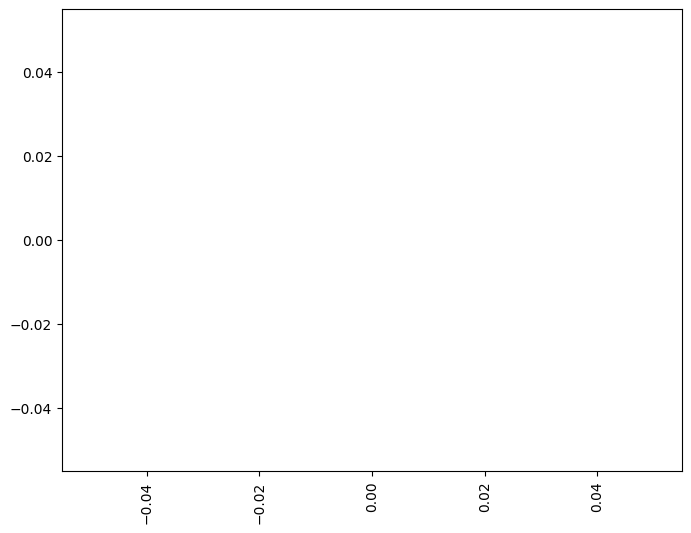

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
data['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Generate word cloud for each sentiment category
for label in data['label'].unique():
    wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data[data['label'] == label]['processed_text']))
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Word Cloud for {label} Posts')
    plt.axis('off')
    plt.show()


# División de datos, entrenamiento y evaluación del modelo

In [ ]:
# Python code for data splitting, model training, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], data['label'], test_size=0.2, random_state=42)

# Build a pipeline for model training and evaluation
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
